# Assignment 05 - COVID-19 Cases Prediction in Alberta

The goal of this assignment is for you to create a recurrent neural network model to predict new daily cases of COVID-19 in Alberta up to seven days in the future. The deliverable for this assignment is this jupyter-notebook completed with your solution. Name the notebook as enel645_assignment05_team_(team number).ipynb. Submit the notebook to your team dropbox in the course D2L page.

We will be using the University of Oxford Blavatnik School of Government dataset. They are tracking coronavirus government responses since January 1st, 2020. They have collected information across different countries and regions. For this assignment, we will focus in the province of Alberta, Canada.

The dataset was already pre-processed to handle missing values, etc. You can focus just on your model development. Only edit the sections indicated in this notebook. You are free to add extra cells of text and code to this sections.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20%
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30%
4. Accuracy of the models - 30%

## Don't edit the cells below

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

In [23]:
# Features - information about the features can be found here:
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md
columns = ['Date', 'C1_School closing','C2_Workplace closing','C3_Cancel public events',\
           'C4_Restrictions on gatherings','C5_Close public transport','C6_Stay at home requirements',\
           'C7_Restrictions on internal movement','C8_International travel controls', 'E1_Income support',\
           'E1_Flag', 'E2_Debt/contract relief','E3_Fiscal measures', 'E4_International support',\
           'H1_Public information campaigns','H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',\
           'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6_Facial Coverings',\
           'H6_Flag', 'H7_Vaccination policy','H7_Flag', 'H8_Protection of elderly people', \
           'ConfirmedCases']

# Load the dataset
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df = pd.read_csv(DATA_URL,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

# We are only interested in Alberta
df  = df[(df["RegionName"] == "Alberta")]

In [3]:
# Keep only the columns that we want and display the first 10 samples
df = df[columns]
df.tail(10)

,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,...,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,ConfirmedCases
26153,2021-03-25,1.0,2.0,2.0,4.0,0.0,0.0,1.0,4.0,1.0,...,2.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,144311.0
26154,2021-03-26,1.0,2.0,2.0,4.0,0.0,0.0,1.0,4.0,1.0,...,2.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,145028.0
26155,2021-03-27,1.0,2.0,2.0,4.0,0.0,0.0,1.0,4.0,1.0,...,2.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,145696.0
26156,2021-03-28,1.0,2.0,2.0,4.0,0.0,0.0,1.0,4.0,1.0,...,2.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,146340.0
26157,2021-03-29,1.0,2.0,2.0,4.0,0.0,0.0,1.0,4.0,1.0,...,2.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,146885.0
26158,2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147461.0
26159,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148332.0
26160,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149207.0
26161,2021-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26162,2021-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Fill missing confirmed cases with 0s (initial cases) and interpolating the remaining
df["ConfirmedCases"].values[:70] = 0
df["ConfirmedCases"] = df["ConfirmedCases"].interpolate()
df["ConfirmedCases"].values[159] = (df["ConfirmedCases"].values[160] + df["ConfirmedCases"].values[158])/2  

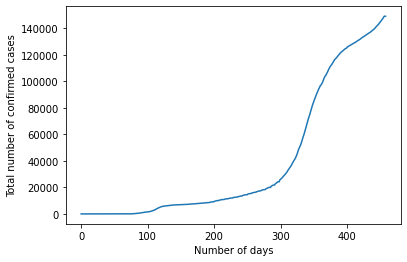

In [5]:
plt.figure()
plt.plot(df["ConfirmedCases"].values)
plt.xlabel("Number of days")
plt.ylabel("Total number of confirmed cases")
plt.show()

In [6]:
df["DailyChangeConfirmedCases"] = df.ConfirmedCases.diff().fillna(0)
df["Cases7DayAverage"]  = df["DailyChangeConfirmedCases"].rolling(7).mean().fillna(0)

# Fill misisng values with -1
for npi_column in columns:
    df[npi_column] = df[npi_column].fillna(-1)

df.tail(10)
df.columns

Index(['Date', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'H8_Protection of elderly people', 'ConfirmedCases',
       'DailyChangeConfirmedCases', 'Cases7DayAverage'],
      dtype='object')

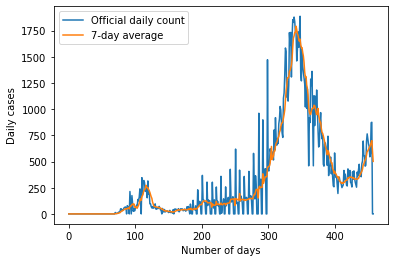

In [7]:
plt.figure()
plt.plot(df["DailyChangeConfirmedCases"].values, label = "Official daily count") 
plt.plot(df["Cases7DayAverage"].values, label = "7-day average")
plt.xlabel("Number of days")
plt.ylabel("Daily cases")
plt.legend()
plt.show()

In [8]:
DAYS_BACK  = 20 # We look 20 days back into the 7 day average to perform our prediction
DAYS_FORWARD = 7 # We want to predict daily cases up to 7 days ahead
X = df[df.columns[1:]].values[:,1:] # Get numpy array from pandas dataframe
X_static = X[DAYS_BACK:-DAYS_FORWARD,:-3] # static features
X_timeseries = np.zeros((X.shape[0]- DAYS_BACK - DAYS_FORWARD,DAYS_BACK)) # time series features, 
                                                                          # i.e., historical daily cases

Y = np.zeros((X.shape[0]- DAYS_BACK - DAYS_FORWARD,DAYS_FORWARD))

# Preparing the time series data and the labels
for ii in range(DAYS_BACK, X.shape[0]- DAYS_FORWARD):
    X_timeseries[ii-DAYS_BACK,:] = X[(ii - DAYS_BACK):ii,-1]
    Y[ii-DAYS_BACK,:] = X[ii:(ii + DAYS_FORWARD),-1]

In [11]:
# Splitting the dataset
X_static_dev = X_static[45:-21]
max_static = X_static_dev.max(axis = 0,keepdims = True)
X_static_dev = X_static_dev/(max_static + 1e-10)
X_timeseries_dev = X_timeseries[45:-21]#[:,:,np.newaxis]
max_temporal = X_timeseries_dev.max()
X_timeseries_dev = X_timeseries_dev/max_temporal
Y_dev = Y[45:-21]

indexes = np.arange(X_static_dev.shape[0])
np.random.shuffle(indexes)
X_static_dev = X_static_dev[indexes]
X_timeseries_dev = X_timeseries_dev[indexes]
Y_dev = Y_dev[indexes]

X_static_test = X_static[-21:-1]
X_static_test = X_static_test/(max_static+1e-10)
X_timeseries_test = X_timeseries[-21:-1]/max_temporal
Y_test = Y[-21:-1]

## Only edit the cells below for the assignment

In [ ]:
# Your model should receive these two inputs
input_A = tf.keras.layers.Input(shape=(X_static_dev.shape[1],), name="inputA")
input_B = tf.keras.layers.Input(shape=(None, 1), name="inputB")

#Define your model here

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputB (InputLayer)             [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 50)     10400       inputB[0][0]                     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 25)           7600        lstm[0][0]                       
__________________________________________________________________________________________________
inputA (InputLayer)             [(None, 23)]         0                                            
______________________________________________________________________________________________

In [14]:
opt = tf.keras.optimizers.SGD(lr= 1e-3) # Feel free to choose your optimizer
model.compile(loss='mae',optimizer=opt)

model_name = "covid_alberta_lstm.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 1300)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%50 == 0 and epoch!= 0:
        lr = lr/1.1
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
history = model.fit((X_static_dev, X_timeseries_dev),Y_dev, epochs=1500, batch_size = 24, \
                    callbacks= [early_stop, monitor, lr_schedule],shuffle = True,\
                    validation_split = 0.2)

## Don't edit the cell below

In [22]:
model.load_weights(model_name)
model.evaluate((X_static_test,X_timeseries_test),Y_test)

1/1 [==============================] - 0s 10ms/step - loss: 78.6585


78.65853118896484

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...